# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    *  Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    *  Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    *  Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Дополнительные вопросы для HR-агенства:
    * Как соотноситья оплата труда от опыта работы специалиста?
    * Как соотноситься оплата труда от типа трудоустройства? 
    * Есть ли связь между размером компании и типом трудоустройства сотрудников? 
    * Есть ли связь между размером компании и объемом удаленно выполняемой работы?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Данные содержат следующие признаки:

|НАИМЕНОВАНИЕ СТОЛБЦА|	ОПИСАНИЕ|
|--|--|
|work_year	|Год, в котором была выплачена зарплата.|
|experience_level	|Опыт работы на этой должности в течение года со следующими возможными значениями:* EN — Entry-level/Junior; * MI — Mid-level/Intermediate; * SE — Senior-level/Expert; * EX — Executive-level/Director. |
|employment_type	|Тип трудоустройства для этой роли: * PT — неполный рабочий день * FT — полный рабочий день; * CT — контракт; FL — фриланс. |
job_title	|Роль, в которой соискатель работал в течение года.
salary	|Общая выплаченная валовая сумма заработной платы.
salary_currency	|Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
salary_in_usd	|Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
employee_residence	|Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
remote_ratio	|Общий объём работы, выполняемой удалённо. Возможные значения: * 0 — удалённой работы нет (менее 20 %); * 50 — частично удалённая работа; * 100 — полностью удалённая работа (более 80 %).
company_location	|Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
company_size	|Среднее количество людей, работавших в компании в течение года: * S — менее 50 сотрудников (небольшая компания); * M — от 50 до 250 сотрудников (средняя компания);* L — более 250 сотрудников (крупная компания).

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [51]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from ydata_profiling import ProfileReport

In [52]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head(3)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


In [53]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

<Axes: >

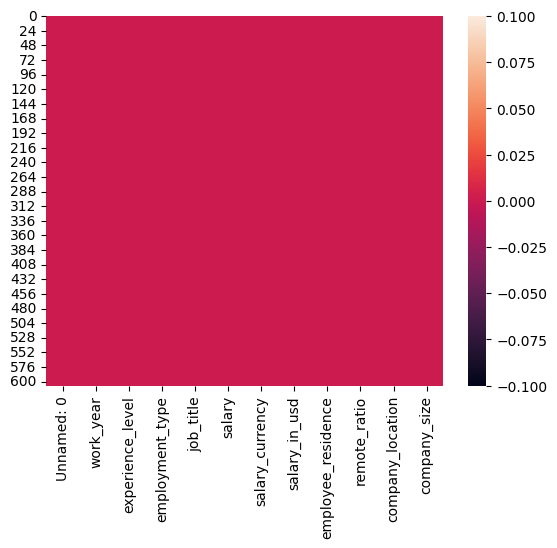

In [54]:
sns.heatmap(data.isnull()) # наглядная карта пропусков

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [56]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


### Начисление зарплат специалистам Data Scientist

Тест №1 Проверка на нормальность - Гистограмма 

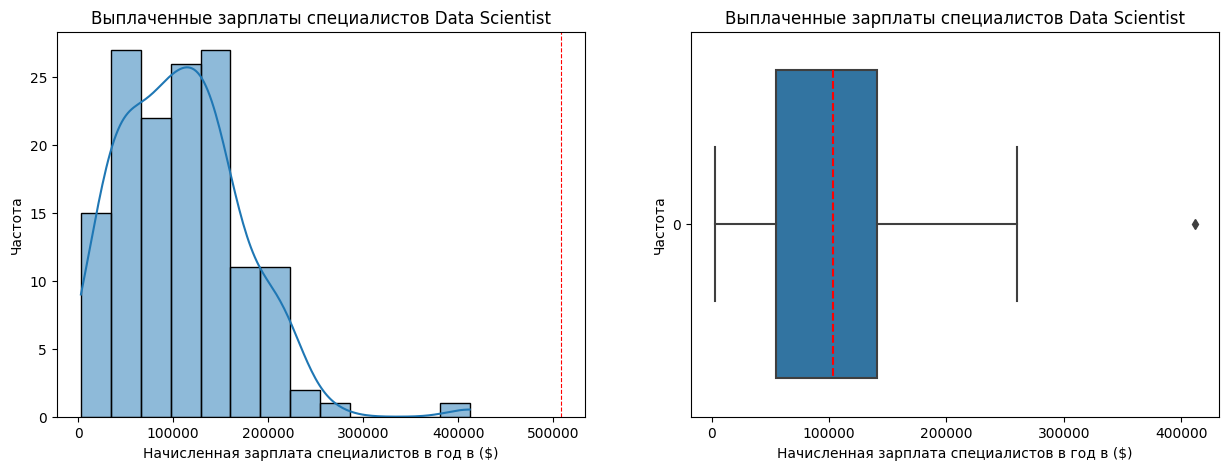

In [ ]:
# Создаем фильтр и отбираем подходящие значения 
data_ds = data[data['job_title'] == 'Data Scientist']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_ds['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Начисленная зарплата специалистов в год в ($)', ylabel='Частота')
axes[0].set_title('Выплаченные зарплаты специалистов Data Scientist')
axes[0].axvline(data_ds['salary'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_ds['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Частота', xlabel='Начисленная зарплата специалистов в год в ($)')
axes[1].set_title('Выплаченные зарплаты специалистов Data Scientist')

plt.show()

Тест №1 - показывает, что данные распределены не нормально - присутсвует пенек на отметке в 400 тыс. и на диограмме с усами присутвует точка с выбросом на отметке в 400 тыс. Для подтверждения увиденного провожу следующий тест.

Тест №2 Проверка на нормальность - КВАНТИЛЬ-КВАНТИЛЬ ГРАФИК

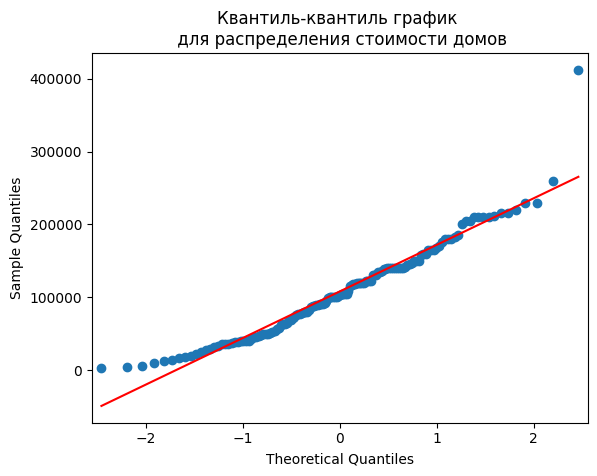

In [ ]:
# задаём параметры квантиль-квантиль графика
sm.qqplot(data_ds['salary_in_usd'], line='s')
plt.title('Квантиль-квантиль график \n для распределения стоимости домов')

# отображаем квантиль-квантиль график
plt.show()

Тест №2 - показывает, что данные распределены не нормально.

In [ ]:
data_agg = data_ds['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Изменение зарплат у специалистов в год']
data_agg

,Изменение зарплат у специалистов в год
count,143.00
mean,108187.83
std,64112.84
min,2859.00
25%,54724.00
50%,103691.00
75%,140850.00
max,412000.00


Итог: расределение зарплат у специалистов отлично от нормального, имеются выбросы. 

### Ежегодное изменение зарплат у специалистов DS 

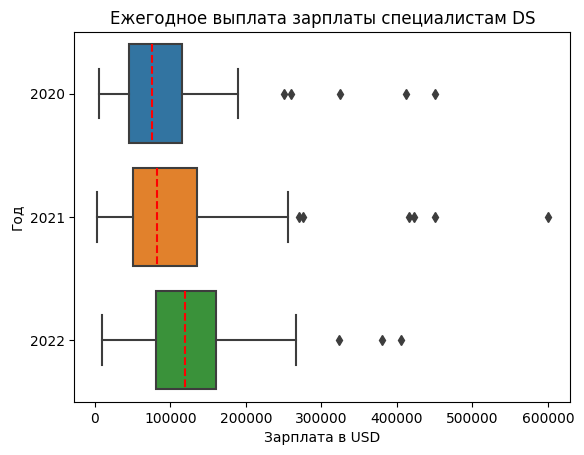

In [ ]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в USD', ylabel='Год')
plt.title('Ежегодное выплата зарплаты специалистам DS')
plt.show()

In [ ]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Ежегодное выплата зарплаты специалистам DS')
data_agg

Ежегодное выплата зарплаты специалистам DS


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


На первый взгляд распределения зарплат по годам различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.


### Измерение зарплат Data Scientist и Data Engineer в 2022 году

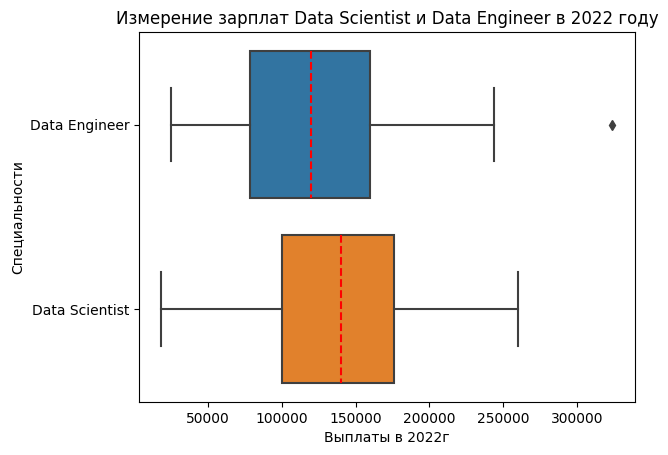

In [ ]:
# Создаем фильтр и отбираем подходящие значения 
data_ds_de = ['Data Scientist','Data Engineer']
data_ds_de_year = data[(data['work_year'] == 2022) & (data['job_title'].isin(data_ds_de))]

#Строим график для отображения дланных
ax = sns.boxplot(data_ds_de_year, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Выплаты в 2022г', ylabel='Специальности')
plt.title('Измерение зарплат Data Scientist и Data Engineer в 2022 году')
plt.show()

In [ ]:
data_agg = data_ds_de_year.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Измерение зарплат Data Scientist и Data Engineer в 2022 году')
data_agg

Измерение зарплат Data Scientist и Data Engineer в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126375.70,55954.40,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Распределение зарплат в 2022 году различны в зависимости от специальности  Data Engineer или  Data Scientist. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Начисление зарплаты специалистам Data Scientist в зависимости от размера организации

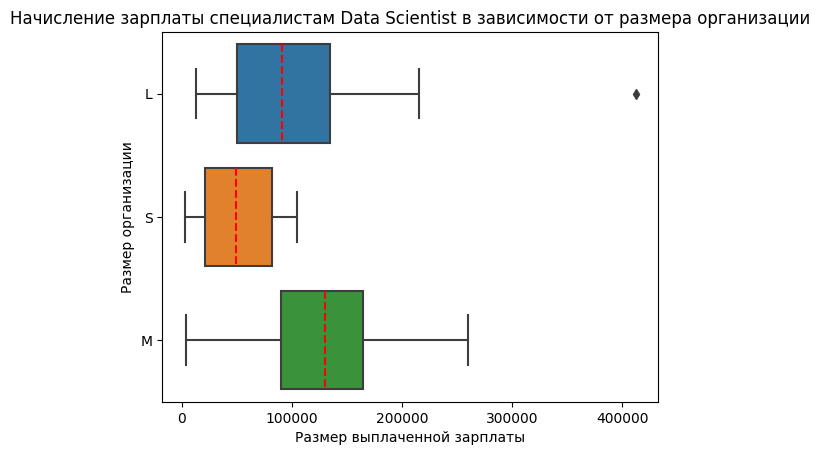

In [ ]:
#Строим график для отображения данных
ax = sns.boxplot(data_ds, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер выплаченной зарплаты', ylabel='Размер организации')
plt.title('Начисление зарплаты специалистам Data Scientist в зависимости от размера организации')
plt.show()

In [ ]:
data_agg = data_ds.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Начисление зарплаты специалистам Data Scientist в зависимости от размера организации')
data_agg

Начисление зарплаты специалистам Data Scientist в зависимости от размера организации


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Распределения зарплат Data Scientist-ов различны для разных организаций. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Соотношение должностей Data Scientist и Data Engineer в зависимости размера организации 

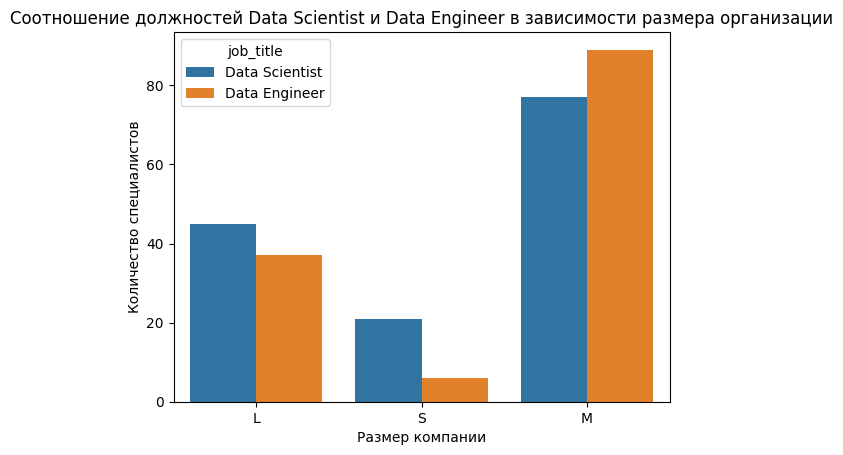

In [ ]:
# Создаем фильтр и отбираем подходящие значения 
data_ds_de_job = data[data['job_title'].isin(data_ds_de)]

#Строим график для отображения данных
ax = sns.countplot(data=data_ds_de_job, x='company_size', hue='job_title')
ax.set(xlabel='Размер компании', ylabel='Количество специалистов')
plt.title('Соотношение должностей Data Scientist и Data Engineer в зависимости размера организации')
plt.show()

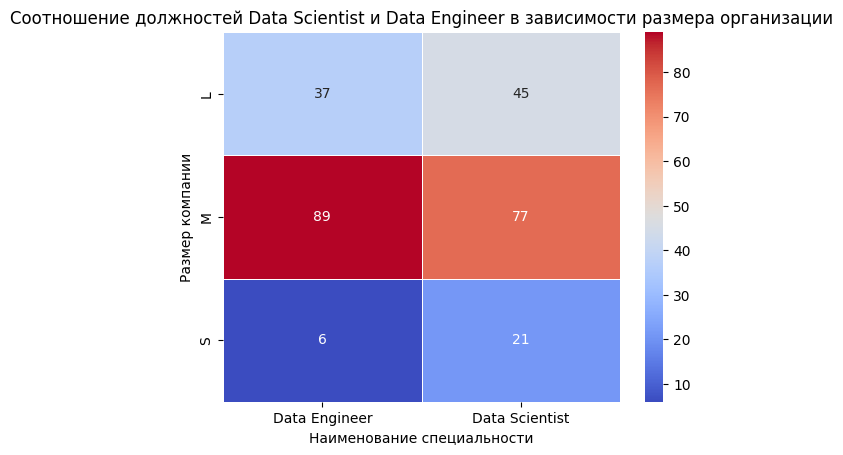

In [ ]:
cross_tab = pd.crosstab(index=data_ds_de_job['company_size'], columns=data_ds_de_job['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Наименование специальности', ylabel='Размер компании')
plt.title('Соотношение должностей Data Scientist и Data Engineer в зависимости размера организации')
plt.show()

Согласно данным, специалистов Data Engineer больше находятся в компаниях уровня "М", однако этих же специлостов самое маленькое количество в компаниях уровня "S". Специалисты Data Scientist, более равномерно распределены. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Влияет ли оплата труда от уровня должности

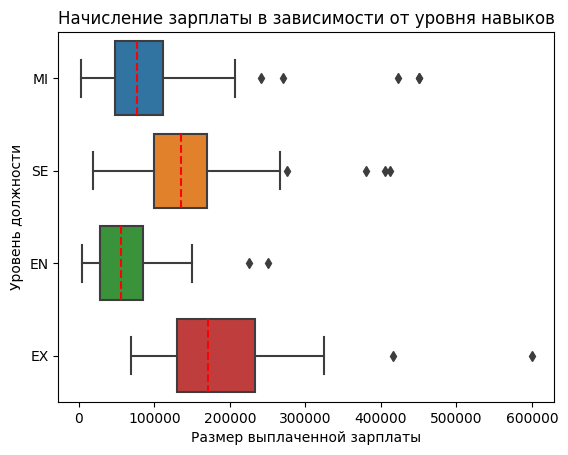

In [ ]:
# Влияет ли оплата труда от уровня должности experience_level от salary_in_usd? 

ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер выплаченной зарплаты', ylabel='Уровень должности')
plt.title('Начисление зарплаты в зависимости от уровня навыков')
plt.show()

In [ ]:
data_sal_ex = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Начисление зарплаты в зависимости от уровня навыков')
data_sal_ex

Начисление зарплаты в зависимости от уровня навыков


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.0,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.5,171437.5,233750.00,600000.0
MI,213.0,87996.06,63901.06,2859.0,48000.0,76940.0,112000.00,450000.0
SE,280.0,138617.29,57691.98,18907.0,100000.0,135500.0,170000.00,412000.0


Распределения зарплат различны для разных уровней навыков. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Влияет ли тип трудоустройства от зарплаты?

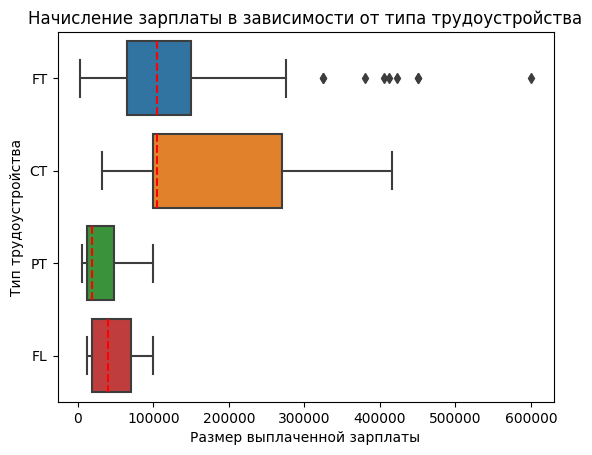

In [ ]:
# Влияет ли тип трудоустройства от зарплаты employment_type от salary_in_usd?

ax = sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер выплаченной зарплаты', ylabel='Тип трудоустройства')
plt.title('Начисление зарплаты в зависимости от типа трудоустройства')
plt.show()

In [ ]:
data_sal_emp = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Начисление зарплаты в зависимости от типа трудоустройства')
data_sal_emp

Начисление зарплаты в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0
FT,588.0,113468.07,69476.47,2859.0,64962.25,104196.5,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0


Распределения зарплат различны для разных типов трудоустройства. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Влияет ли размер компании от типа трудоустроенных людей в компании 

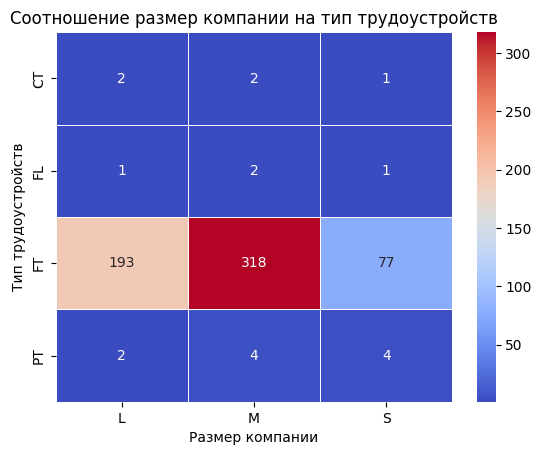

In [ ]:
# Влияет ли размер компании от типа трудоустроенных людей в компании employment_type от  company_size

cross_tab = pd.crosstab(index=data['employment_type'], columns=data['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Тип трудоустройств')
plt.title('Соотношение размер компании на тип трудоустройств')
plt.show()

Согласно данным, большинство специалистов находятся работают по типу трудоустройства FT - полный рабочий день. То есть работают в офисе. Также этих специалистов больше всего находятся в компаниях среднего размера тип M. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Влияет ли размер компании на объем выполняемой работы удаленно? 

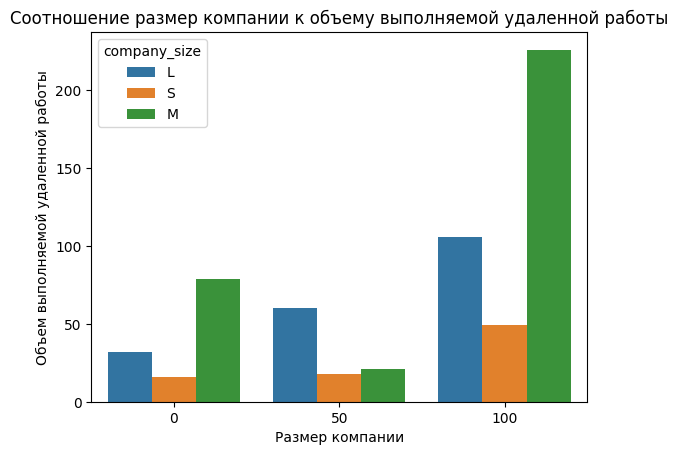

In [ ]:
# Соотношение размер компании к объему выполняемой удаленной работы
ax = sns.countplot(data=data, x=data['remote_ratio'], hue='company_size')
ax.set(xlabel='Размер компании', ylabel='Объем выполняемой удаленной работы')
plt.title('Соотношение размер компании к объему выполняемой удаленной работы')
plt.show()

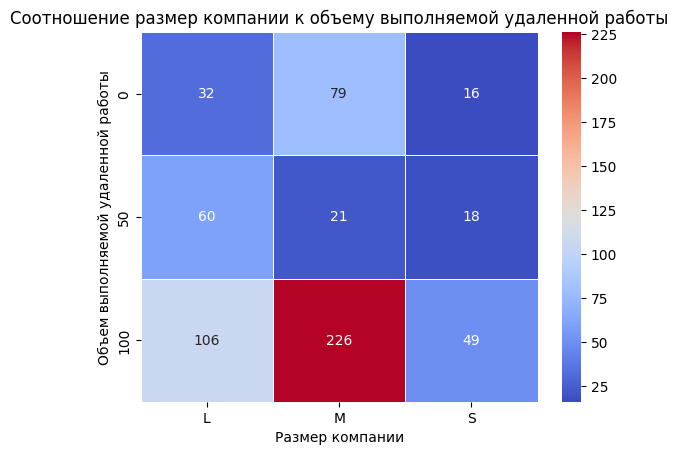

In [ ]:
# Влияет ли размер компании на объем выполняемой работы удаленно company_size от remote_ratio? 

cross_tab = pd.crosstab(index=data['remote_ratio'], columns=data['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Объем выполняемой удаленной работы')
plt.title('Соотношение размер компании к объему выполняемой удаленной работы')
plt.show()

Согласно данным, во всех пересечениях пристутсвует некая связь, безусловно сильная связь наблюдается в категории полностью удаленного формата работы в уровнях компании типа "S" и "M". Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных

In [ ]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплата специалистов Data Scientist не меняется год от года (m).

$$ H_0 : m = 1$$

*Альтернативная гипотеза* ($H_1$): 
зарплата специалистов Data Scientist (m) увеличивается каждый год.


$$ H_1 : m > 1$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [ ]:
# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_ds['salary_in_usd'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')


p-value = 0.000
Распределение не нормальное


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Выплата зарплаты»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Критерий Краскела-Уоллиса для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
from scipy.stats import kruskal

# Годовые данные о зарплатах специалистов Data Scientist за 3 года
data_ds_year1 = data_ds.loc[data_ds['work_year'] == 2020, 'salary_in_usd']
data_ds_year2 = data_ds.loc[data_ds['work_year'] == 2021, 'salary_in_usd']
data_ds_year3 = data_ds.loc[data_ds['work_year'] == 2022, 'salary_in_usd']

# Проводим тест Краскела-Уоллиса
result = statistic, p_value = kruskal(data_ds_year1, data_ds_year2, data_ds_year3)
decision_hypothesis(result[1])


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплата специалистов Data Scientist увеличивается каждый год

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплата Data Scientist ($μ_1$) в 2022 году равна зарплате Data Engineer ($μ_2$) в 2022 году.

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): зарплата Data Scientist ($μ_1$) в 2022 году отличается от зарплаты Data Engineer ($μ_2$) в 2022 году 

$$ H_1 :  μ_1 != μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
data_year = data[data['work_year'] == 2022]
data_year_ds = data_year.loc[data_year['job_title']=='Data Scientist', 'salary_in_usd']
data_year_de = data_year.loc[data_year['job_title']=='Data Engineer', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для специалистов Data Scientist:')
result = stats.shapiro(data_year_ds)
decision_normality(result[1])

print('Для специалистов  Data Engineer:')
result = stats.shapiro(data_year_de)
decision_normality(result[1])

Для специалистов Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов  Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Выплата зарплаты»? — Количественный.
* Сколько сравниваемых групп? — две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна-Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
import scipy.stats as stats

# проводим тест
_, p = stats.mannwhitneyu(data_year_ds, data_year_de)
decision_hypothesis(p)


p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что зарплаты специалистов Data Scientist и Data Engineer имееют сильное различие.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплата специалистов Data Scientist ($μ_1$)не зависит от размера компании (S, M, L).

$$ H_0 : μ_1 != μ_S != μ_M != μ_L$$

*Альтернативная гипотеза* ($H_1$): зарплата специалистов Data Scientist ($μ_1$) зависит от размера компании(S, M, L).

$$ H_1 : μ_1 = μ_S = μ_M = μ_L$$

In [ ]:
# значения страховых выплат
data_ds_s = data_ds.loc[data_ds['company_size']=='S', 'salary_in_usd']
data_ds_m = data_ds.loc[data_ds['company_size']=='M', 'salary_in_usd']
data_ds_l = data_ds.loc[data_ds['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для специалистов Data Scientist и размер компании S:')
result = stats.shapiro(data_ds_s)
decision_normality(result[1])

print('Для специалистов  Data Engineer и размер компании M:')
result = stats.shapiro(data_ds_m)
decision_normality(result[1])

print('Для специалистов  Data Engineer и размер компании L:')
result = stats.shapiro(data_ds_l)
decision_normality(result[1])

Для специалистов Data Scientist и размер компании S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов  Data Engineer и размер компании M:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов  Data Engineer и размер компании L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Выплата зарплаты»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Критерий Краскела-Уоллиса для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
# Проводим тест Краскела-Уоллиса
result = statistic, p_value = kruskal(data_ds_s, data_ds_m, data_ds_l)
decision_hypothesis(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплата специалистов Data Scientist зависит от размера компании! 

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: нет связи между наличием должностей Data Scientist и Data Engineer и размером компании. (признаки независимы).

*Альтернативная гипотеза*: существует связь между наличием должностей Data Scientist и Data Engineer и размером компании (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [ ]:
# Отбираем только строки, где должность является 'Data Scientist' или 'Data Engineer'
filtered_data = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]

# Создаем кросс-таблицу
crosstab = pd.crosstab(filtered_data['company_size'], filtered_data['job_title'])

# Выводим кросс-таблицу
crosstab


job_title,Data Engineer,Data Scientist
company_size,,
L,37,45
M,89,77
S,6,21


In [ ]:
_, p, _, _ = stats.chi2_contingency(crosstab)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между выбором должности и размером организации.

### Влияет ли оплата труда от уровня должности

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: оплата труда не зависит от уровня должности.

*Альтернативная гипотеза*: оплата труда зависит от уровня должности.


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
data_sal_ex_en = data_year.loc[data_year['experience_level']=='EN', 'salary_in_usd']
data_sal_ex_ex = data_year.loc[data_year['experience_level']=='EX', 'salary_in_usd']
data_sal_ex_mi = data_year.loc[data_year['experience_level']=='MI', 'salary_in_usd']
data_sal_ex_se = data_year.loc[data_year['experience_level']=='SE', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Уровень специалиста Entry-level/Junior:')
result = stats.shapiro(data_sal_ex_en)
decision_normality(result[1])

print('Уровень специалиста Executive-level/Director:')
result = stats.shapiro(data_sal_ex_ex)
decision_normality(result[1])

print('Уровень специалиста Mid-level/Intermediate:')
result = stats.shapiro(data_sal_ex_mi)
decision_normality(result[1])

print('Уровень специалиста Senior-level/Expert:')
result = stats.shapiro(data_sal_ex_se)
decision_normality(result[1])

Уровень специалиста Entry-level/Junior:
p-value = 0.167
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Уровень специалиста Executive-level/Director:
p-value = 0.816
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Уровень специалиста Mid-level/Intermediate:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Уровень специалиста Senior-level/Expert:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Выплата зарплаты»? — Количественный.
* Сколько сравниваемых групп? — четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Критерий Краскела-Уоллиса для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
# Проводим тест Краскела-Уоллиса
result = statistic, p_value = kruskal(data_sal_ex_en, data_sal_ex_ex, data_sal_ex_mi, data_sal_ex_se)
decision_hypothesis(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Специалисты малого уровня обладают схожими зарплаты между собой и только, когда специалисты выростают до уровня эксперта, то зарплатные выплаты начинают отличаться от нормального.

### Как соотноситься оплата труда от типа трудоустройства? 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: оплата труда не зависит от типа трудоустройства.

*Альтернативная гипотеза*: оплата труда зависит от типа трудоустройства.

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [ ]:
# делаем первоночальный фильтр по типу трудоустройств 
data_ds_ct = data.loc[data['employment_type']=='CT', 'salary_in_usd']
data_ds_fl = data.loc[data['employment_type']=='FL', 'salary_in_usd']
data_ds_ft = data.loc[data['employment_type']=='FT', 'salary_in_usd']
data_ds_pt = data.loc[data['employment_type']=='PT', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для специалистов и тип трудоустройства CT:')
result = stats.shapiro(data_ds_ct)
decision_normality(result[1])

print('Для специалистов и тип трудоустройства FL:')
result = stats.shapiro(data_ds_fl)
decision_normality(result[1])

print('Для специалистов и тип трудоустройства FT:')
result = stats.shapiro(data_ds_ft)
decision_normality(result[1])

print('Для специалистов и тип трудоустройства PT:')
result = stats.shapiro(data_ds_pt)
decision_normality(result[1])

Для специалистов и тип трудоустройства CT:
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов и тип трудоустройства FL:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов и тип трудоустройства FT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для специалистов и тип трудоустройства PT:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Выплата зарплаты»? — Количественный.
* Сколько сравниваемых групп? — четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Критерий Краскела-Уоллиса для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
# Проводим тест Краскела-Уоллиса
result = statistic, p_value = kruskal(data_ds_ct, data_ds_fl, data_ds_ft, data_ds_pt)
decision_hypothesis(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Специлисты работающие по разным типам трудоустройствам (графикам), имеют разные зарплаты, следовательно отвергаем нулевую гипотезу.

### Влияет ли размер компании от типа трудоустроенных людей в компании? 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: существенной связи между размером компании и типом трудоустройства нет.

*Альтернативная гипотеза*: существует связь между размером компании и типом трудоустройства.


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [ ]:
# Отбираем только строки по типу работы и размером компании 
# Создаем кросс-таблицу
cros_cm_em = pd.crosstab(data['company_size'], data['employment_type'])

# Выводим кросс-таблицу
cros_cm_em


employment_type,CT,FL,FT,PT
company_size,,,,
L,2,1,193,2
M,2,2,318,4
S,1,1,77,4


In [ ]:
_, p, _, _ = stats.chi2_contingency(cros_cm_em)
decision_hypothesis(p)

p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет основанйи отвергать нулевую гипотезу, следовательно категории размер компании и тип трудоустройства специалиста между собой не связаны.

### Соотношение размер компании к объему выполняемой удаленной работы

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: существенной связи между размером компании и типом трудоустройства нет.

*Альтернативная гипотеза*: существует связь между размером компании и типом трудоустройства.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [ ]:
# Отбираем только строки по типу работы и объему работ 
# Создаем кросс-таблицу
cros_cm_rm = pd.crosstab(data['company_size'], data['remote_ratio'])

# Выводим кросс-таблицу
cros_cm_rm


remote_ratio,0,50,100
company_size,,,
L,32,60,106
M,79,21,226
S,16,18,49


In [ ]:
_, p, _, _ = stats.chi2_contingency(cros_cm_rm)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между уровнем организацией и объемом выполняемой удаленной работы.

## Итоговые результаты исследования
1. Ответы на ключевые вопросы HR-агенства:
*   Зарплата специалистов Data Scientist увеличивается каждый год;
*   Нет оснований утверждать, что зарплаты специалистов Data Scientist и Data Engineer имееют сильное различие;
*   Зарплата специалистов Data Scientist зависит от размера компании!;
*   Существует статистически значимая взаимосвязь между выбором должности и размером организации.
2. Дополнительные ответы для HR-агенства: 
*   Специалисты малого уровня обладают схожими зарплаты между собой и только, когда специалисты выростают до уровня эксперта, то зарплатные выплаты начинают отличаться от нормального;
* Специлисты работающие по разным типам трудоустройствам (графикам), имеют разные зарплаты, следовательно отвергаем нулевую гипотезу;
* Нет основанйи отвергать нулевую гипотезу, следовательно категории размер компании и тип трудоустройства специалиста между собой не связаны;
* Существует статистически значимая взаимосвязь между уровнем организацией и объемом выполняемой удаленной работы.